In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

## Product Keyword Analysis

In [47]:
data = pd.read_csv('data.csv')

In [48]:
product_descriptions = data['product_description']

In [49]:
product_descriptions_filled = product_descriptions.fillna('nodesc')

In [50]:
tfidf_vectorizer = TfidfVectorizer(max_features=20, stop_words='english')

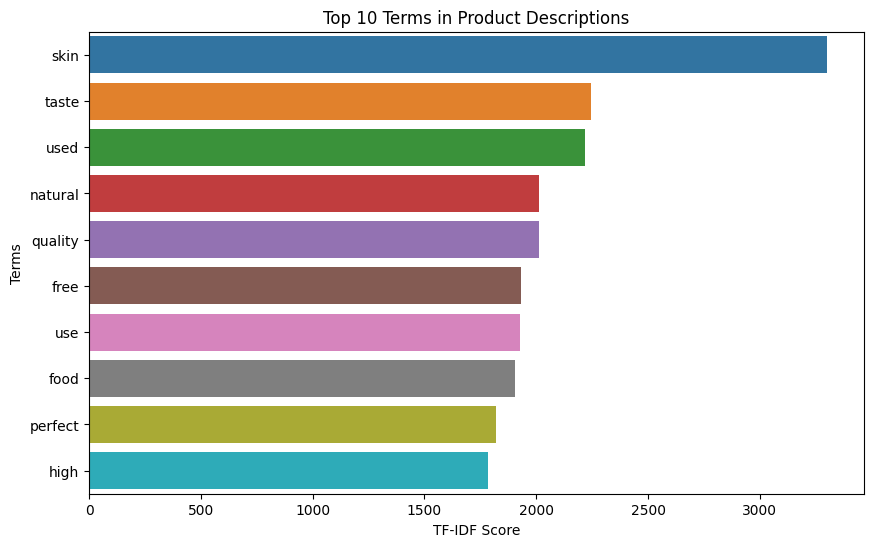

In [51]:
tfidf_matrix = tfidf_vectorizer.fit_transform(product_descriptions_filled)

# Summarize the TF-IDF values to find the most important words
sums = tfidf_matrix.sum(axis=0)
terms = tfidf_vectorizer.get_feature_names_out()
data_items = [(terms[i], sums[0, i]) for i in range(sums.shape[1])]
tfidf_summary = pd.DataFrame(data_items, columns=['term', 'tfidf']).sort_values(by='tfidf', ascending=False)

# Plot the top terms
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='term', data=tfidf_summary.head(10))
plt.title('Top 10 Terms in Product Descriptions')
plt.xlabel('TF-IDF Score')
plt.ylabel('Terms')
plt.show()


## Product Keyword Based on Customer Demographics

In [52]:
file_path = 'data.csv'
data = pd.read_csv(file_path)

data['product_description'] = data['product_description'].fillna('no description')


def extract_top_keywords(descriptions, top_n=10):

    descriptions = [str(desc) for desc in descriptions]
    vectorizer = CountVectorizer(max_features=top_n, stop_words='english')
    matrix = vectorizer.fit_transform(descriptions)
    sums = matrix.sum(axis=0)
    terms = vectorizer.get_feature_names_out()
    keywords = [(terms[i], sums[0, i]) for i in range(sums.shape[1])]
    return sorted(keywords, key=lambda x: x[1], reverse=True)


segmented_data = defaultdict(list)
for index, row in data.iterrows():
    segmented_data[row['customer_demographics']].append(row['product_description'])

keywords_by_demographic = {
    demographic: extract_top_keywords(descriptions)
    for demographic, descriptions in segmented_data.items()
}

keywords_by_demographic


{'Female': [('skin', 5219),
  ('hair', 2706),
  ('natural', 2537),
  ('oil', 2347),
  ('free', 2084),
  ('use', 1895),
  ('healthy', 1844),
  ('helps', 1809),
  ('used', 1796),
  ('quality', 1759)],
 'Other': [('skin', 5061),
  ('hair', 2630),
  ('oil', 2423),
  ('natural', 2374),
  ('free', 2021),
  ('food', 1870),
  ('quality', 1847),
  ('use', 1811),
  ('used', 1800),
  ('helps', 1769)],
 'Male': [('skin', 5790),
  ('hair', 2566),
  ('natural', 2372),
  ('oil', 2337),
  ('free', 2009),
  ('use', 1950),
  ('helps', 1881),
  ('food', 1850),
  ('quality', 1837),
  ('used', 1772)]}

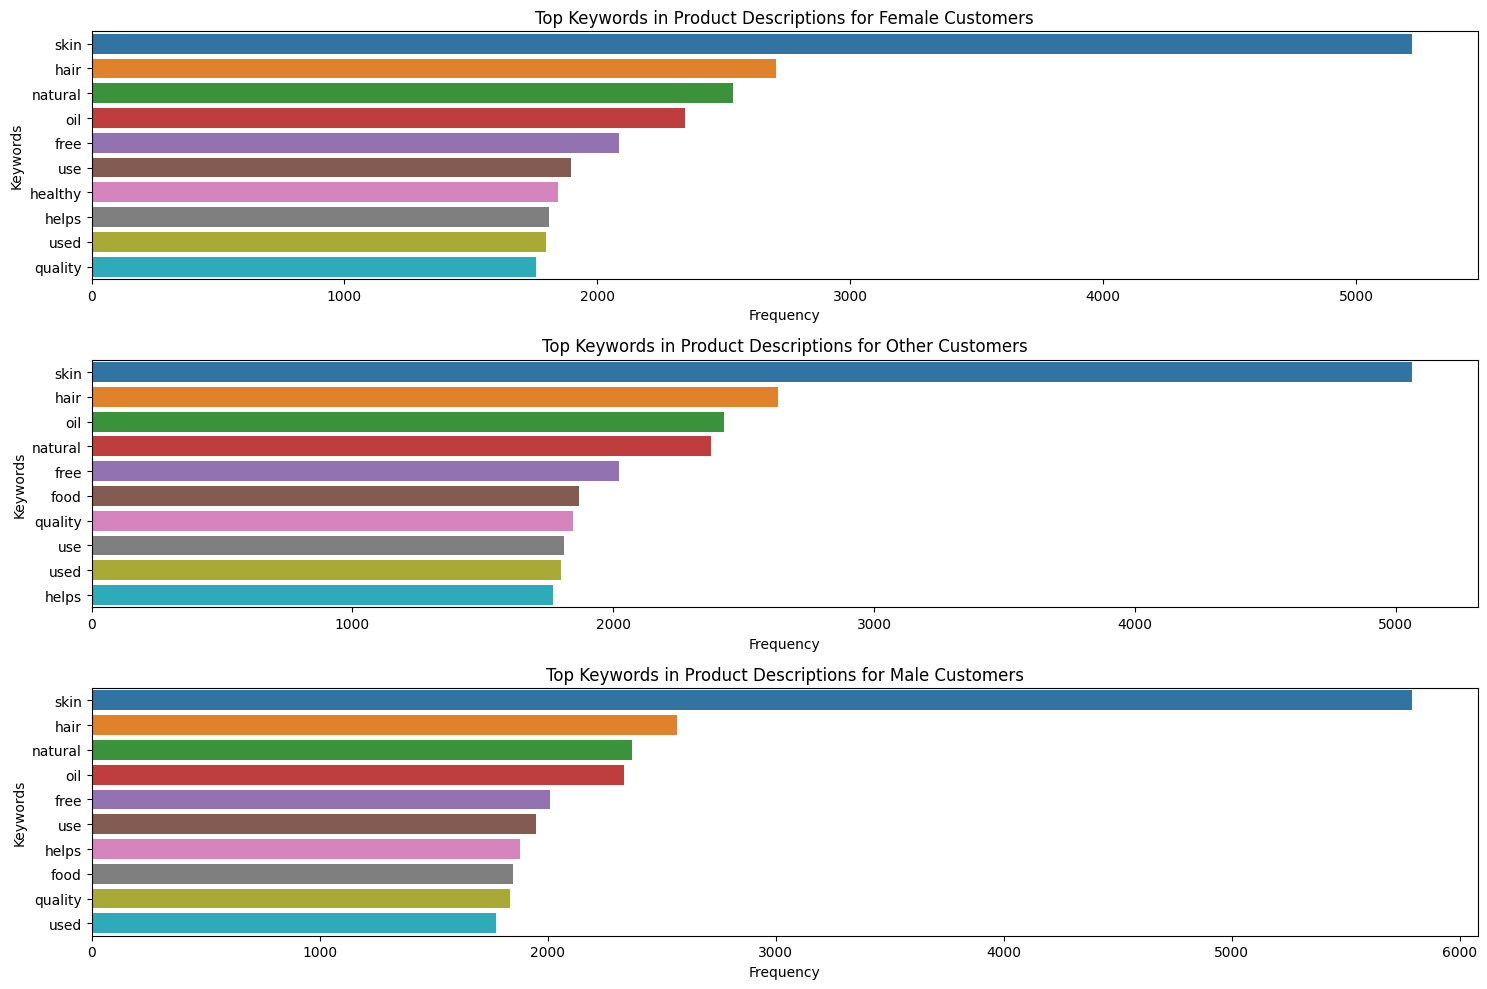

In [53]:
# Plotting the top keywords for each customer demographic
plt.figure(figsize=(15, 10))
for i, (demographic, keywords) in enumerate(keywords_by_demographic.items(), 1):
    plt.subplot(3, 1, i)
    keywords_df = pd.DataFrame(keywords, columns=['Keyword', 'Frequency'])
    sns.barplot(x='Frequency', y='Keyword', data=keywords_df)
    plt.title(f'Top Keywords in Product Descriptions for {demographic} Customers')
    plt.xlabel('Frequency')
    plt.ylabel('Keywords')

plt.tight_layout()
plt.show()



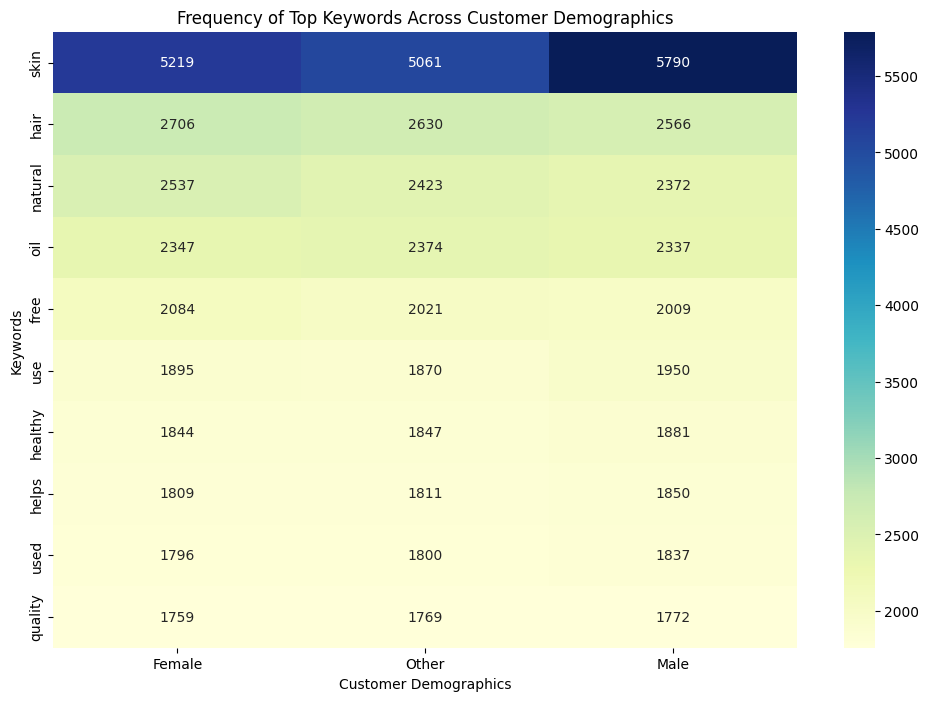

In [54]:
import numpy as np

keywords_matrix = pd.DataFrame(index=np.arange(10), columns=keywords_by_demographic.keys())

for demographic, keywords in keywords_by_demographic.items():
    for idx, (keyword, frequency) in enumerate(keywords):
        keywords_matrix.loc[idx, demographic] = frequency

top_keywords = [keyword for keyword, _ in keywords_by_demographic['Female']]  # Assuming common keywords
keywords_matrix.index = top_keywords

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(keywords_matrix.astype(float), annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Frequency of Top Keywords Across Customer Demographics')
plt.xlabel('Customer Demographics')
plt.ylabel('Keywords')
plt.show()



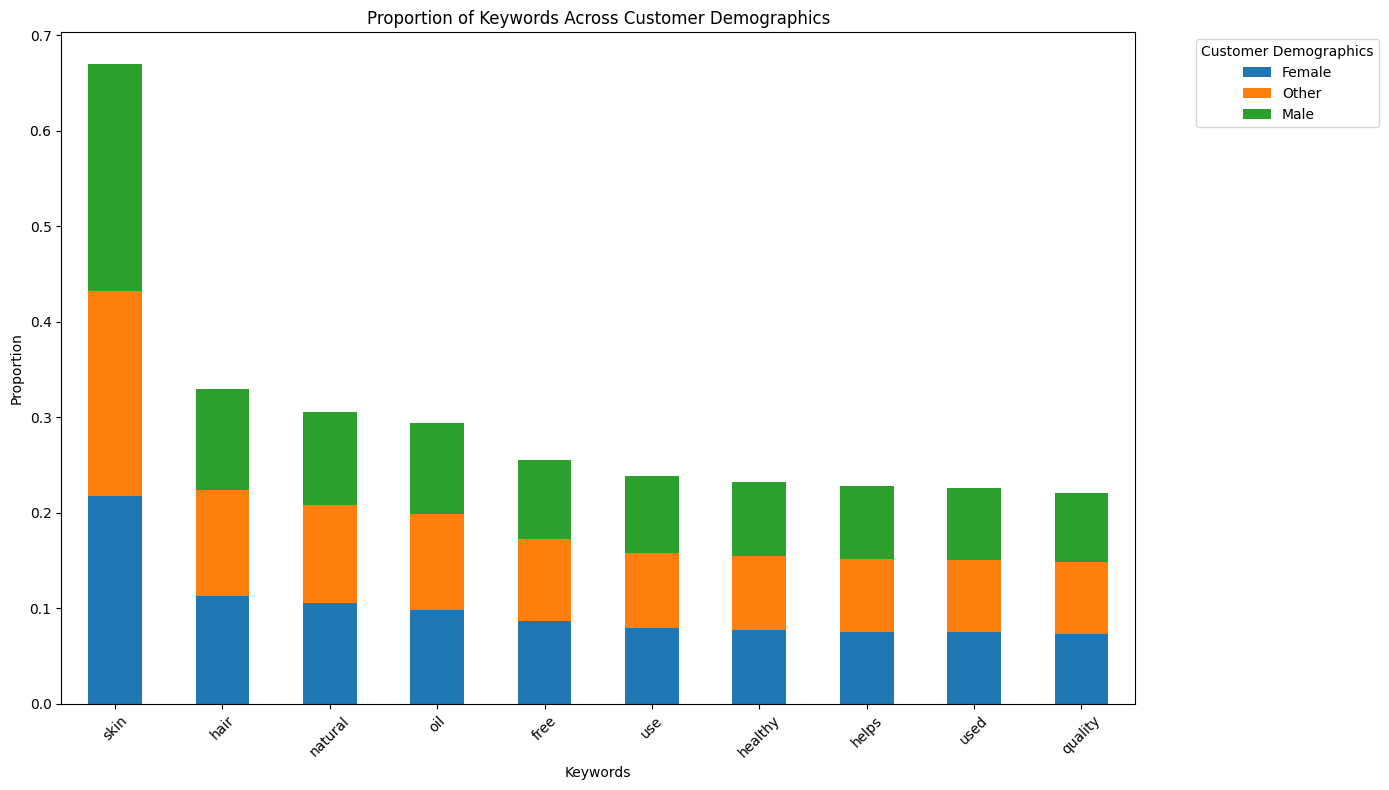

In [55]:
# Calculate the proportion of each keyword within each demographic group
keywords_proportion = keywords_matrix.div(keywords_matrix.sum(axis=0), axis=1)

# Plotting the stacked bar chart
keywords_proportion.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Proportion of Keywords Across Customer Demographics')
plt.xlabel('Keywords')
plt.ylabel('Proportion')
plt.legend(title='Customer Demographics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



## Correlation between Product Description Length and Review Count

In [56]:
data = pd.read_csv('data.csv')

In [57]:
data['product_description'] = data['product_description'].fillna('no description')
data['customer_reviews_count'] = pd.to_numeric(data['customer_reviews_count'], errors='coerce')


In [58]:
data['description_length'] = data['product_description'].apply(len)

In [59]:
correlation = data[['description_length', 'customer_reviews_count']].corr()
print(correlation)


                        description_length  customer_reviews_count
description_length                1.000000               -0.001763
customer_reviews_count           -0.001763                1.000000


**Very Weak Relationship:** The correlation is close to 0, which suggests that there is almost no linear relationship between the length of product descriptions and the number of customer reviews. This implies that changes in the length of the product description do not significantly affect the number of reviews that products receive.

**Negligible Negative Direction:** The negative sign indicates a slight tendency that longer product descriptions might be associated with fewer customer reviews, but given the magnitude of the correlation, this relationship is negligible.

## Topic Modeling

In [60]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Number of topics to extract
n_topics = 5

# Preprocess and vectorize the text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['product_description'])

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
lda.fit(dtm)

# Function to display the top words in each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top words in each topic
display_topics(lda, vectorizer.get_feature_names_out(), 10)



Topic 0:
taste tea delicious flavour perfect chocolate healthy snack make protein
Topic 1:
hair fragrance baby beauty tips bigbasket long https day tricks
Topic 2:
organic health natural healthy helps rice used oil rich free
Topic 3:
skin oil natural helps face free wash anti soft germs
Topic 4:
food quality easy use high used home steel safe kitchen


In [61]:
# Assign the most dominant topic to each product
topic_results = lda.transform(dtm)
data['dominant_topic'] = topic_results.argmax(axis=1)

# Aggregate the customer reviews count by the assigned topics
topic_review_counts = data.groupby('dominant_topic')['customer_reviews_count'].sum().reset_index()

# Sort the results to see which topics have the highest review counts
topic_review_counts = topic_review_counts.sort_values(by='customer_reviews_count', ascending=False)

# Display the aggregated review counts by topic
topic_review_counts

# Topic 0:
# taste tea delicious flavour perfect chocolate healthy snack make protein
# Topic 1:
# hair fragrance baby beauty tips bigbasket long https day tricks
# Topic 2:
# organic health natural healthy helps rice used oil rich free
# Topic 3:
# skin oil natural helps face free wash anti soft germs
# Topic 4:
# food quality easy use high used home steel safe kitchen
# map topic_review_counts to topic names
topic_review_counts['dominant_topic'] = topic_review_counts['dominant_topic'].map({
    0: 'taste tea delicious flavour perfect chocolate healthy snack make protein(Food & Beverages & Flavorful Products)',
    1: 'hair fragrance baby beauty tips bigbasket long https day tricks(Beauty & Personal Care)',
    2: 'organic health natural healthy helps rice used oil rich free(Health & Wellness)',
    3: 'skin oil natural helps face free wash anti soft germs(Beauty & Personal Care)',
    4: 'food quality easy use high used home steel safe kitchen(Home & Kitchen)'
})


In [62]:
topic_review_counts

,dominant_topic,customer_reviews_count
0,taste tea delicious flavour perfect chocolate ...,457750
4,food quality easy use high used home steel saf...,262904
3,skin oil natural helps face free wash anti sof...,253112
2,organic health natural healthy helps rice used...,240229
1,hair fragrance baby beauty tips bigbasket long...,162618


In [63]:
import pandas as pd
import plotly.express as px


# Plotting the horizontal bar chart with Plotly Express
fig = px.bar(
    topic_review_counts,
    x='customer_reviews_count',
    y='dominant_topic',
    orientation='h',
    title='Customer Reviews Count by Dominant Topic using Topic Modeling with LDA(Latent Dirichlet Allocation)',
    labels={'customer_reviews_count': 'Customer Reviews Count', 'dominant_topic': 'Dominant Topic'},
    color='customer_reviews_count',  # Color bars based on customer reviews count
    color_continuous_scale='tempo',  # Choose a blue color scale
    hover_name='dominant_topic',     # Show topic info in hover text
    hover_data={'customer_reviews_count': ':,0'}  # Format hover text for customer reviews count
)

# Customizing the layout
fig.update_layout(
    xaxis_title='Customer Reviews Count',
    yaxis_title='Dominant Topic',
    plot_bgcolor='white',    # Set plot background color to white
    font=dict(family='Arial', size=12, color='black'),
    margin=dict(l=100, r=20, t=50, b=50),
    showlegend=False
)

fig.show()


The analysis of product descriptions and customer review counts in the e-commerce data reveals that:

- **Gourmet and Flavorful Products (Topic 0)** are the most popular, with high demand for tasty and quality food items like tea and chocolate, suggesting a strong market for premium consumables.
- **Kitchen and Household Essentials (Topic 4)** also perform well, indicating a preference for high-quality, durable, and easy-to-use products in home and kitchen categories.
- **Skincare and Beauty (Topic 3)**, along with **Health and Wellness (Topic 2)** products, show significant consumer interest, highlighting a trend towards natural, organic, and health-oriented products.
- **Personal Care and Beauty (Topic 1)**, despite being the least reviewed, still represents a sizable market, especially for products related to hair care, fragrances, and baby care.

In summary, e-commerce platforms can leverage these insights to prioritize categories with high consumer engagement, focus on quality and health-conscious products, and tailor marketing strategies to meet the clear consumer demand for premium, health-oriented, and practical household products.

## Text Complexity Analysis with Customer Review Count

In [64]:
import pandas as pd
import textstat

# Calculate the Flesch Reading Ease score for each product description
data['readability_score'] = data['product_description'].apply(textstat.flesch_reading_ease)

# Check the correlation between readability scores and customer reviews count
correlation = data[['readability_score', 'customer_reviews_count']].corr()

print(correlation)


                        readability_score  customer_reviews_count
readability_score                1.000000                0.003102
customer_reviews_count           0.003102                1.000000


The very weak positive correlation between readability scores and customer reviews suggests that the simplicity or complexity of product descriptions has minimal impact on customer engagement. This highlights the importance of focusing on content relevance and quality over readability in e-commerce product descriptions to drive customer interaction.

## Content Analysis
Investigate if certain keywords or themes in product descriptions are associated with higher or lower numbers of customer reviews.

In [65]:
vectorizer = CountVectorizer(max_features=100, stop_words='english')
X = vectorizer.fit_transform(data['product_description'])

# Convert to a DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
dtm_df['customer_reviews_count'] = data['customer_reviews_count']

# Calculate the average number of reviews for products containing each keyword
keyword_review_counts = dtm_df.drop('customer_reviews_count', axis=1).multiply(dtm_df['customer_reviews_count'], axis=0).sum()

# Sort the keywords by the average number of reviews
sorted_keyword_reviews = keyword_review_counts.sort_values(ascending=False)

print(sorted_keyword_reviews.head(10))
print(sorted_keyword_reviews.tail(10))

skin       816664
hair       384241
natural    366652
oil        358824
free       307741
use        281691
helps      275283
food       270669
quality    268705
used       266662
dtype: int64
experience    88022
source        86529
designed      85431
kitchen       85164
add           84980
flavours      84824
pack          83425
leaves        83091
premium       82396
seeds         81721
dtype: int64


In [69]:
import plotly.graph_objects as go
import pandas as pd

# Assuming 'sorted_keyword_reviews' is your Series with keyword average reviews
top_keywords = sorted_keyword_reviews.head(10)
bottom_keywords = sorted_keyword_reviews.tail(10)

# Combine the top and bottom keywords in reverse order to have an ascending trend
plot_data = pd.concat([bottom_keywords[::-1], top_keywords[::-1]])

# Create the lollipop chart
fig = go.Figure()

# Define colors for the plot: red for bottom keywords, green for top keywords
colors = ['red'] * len(bottom_keywords) + ['green'] * len(top_keywords)

# Add lollipops for the combined keywords
fig.add_trace(go.Scatter(
    x=plot_data.values, 
    y=plot_data.index, 
    mode='markers+lines',
    name='Average Reviews',
    marker=dict(color=colors, size=10),
    line=dict(color='gray')
))

# Customize layout
fig.update_layout(
    title='Top and Bottom 10 Keywords by Average Customer Reviews Count(Content Analysis)',
    xaxis_title='Average Customer Reviews',
    yaxis_title='Keywords',
    height=600,  # Adjust the height as necessary
    plot_bgcolor='white',  # Set background color to white
    xaxis=dict(showgrid=False),  # Remove x-axis gridlines
    yaxis=dict(showgrid=False),  # Remove y-axis gridlines
)

# Add a label for top keywords (green) on the right end
fig.add_annotation(
    x=top_keywords.values.mean(),
    y=top_keywords.index[-1],
    text=f'Top 10 Keywords',
    showarrow=False,
    font=dict(color='green'),
    xshift=50,  # Shift to the right
    yshift=50
)

# Add a label for bottom keywords (red) on the left end
fig.add_annotation(
    x=bottom_keywords.values.mean(),
    y=bottom_keywords.index[0],
    text=f'Bottom 10 Keywords',
    showarrow=False,
    font=dict(color='red'),
    xshift=-30,  # Shift to the left
    yshift=-50,  # Shift upwards
)

fig.show()


Analysis of customer review counts associated with keywords in product descriptions reveals that baby-related, health-conscious, and personal care products generate significant consumer engagement, as indicated by keywords like "baby," "organic," and "wash." In contrast, niche or specialized items like "tea," "coffee," and "seeds" attract fewer reviews, suggesting focused but smaller market segments. The difference in review counts highlights varied consumer interests, from general health and wellness to specific dietary or personal care preferences, guiding e-commerce platforms to tailor product offerings and marketing strategies accordingly.

## Word Cloud

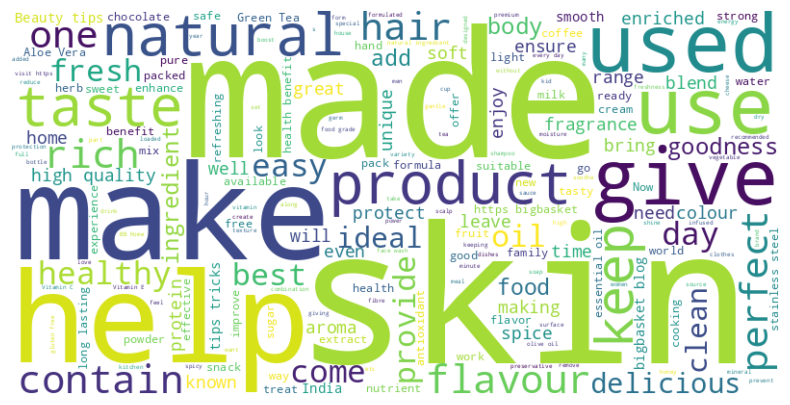

In [73]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data.csv')

# Filter the data to include only product descriptions with a rating greater than 4
high_rating_data = data[data['product_rating'] > 4]['product_description']

# Combine all relevant product descriptions into a single string
high_rating_text = ' '.join(high_rating_data.dropna().astype(str))

# Generate a word cloud image for high rating descriptions
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    width=800,
    height=400
).generate(high_rating_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [76]:
data = pd.read_csv('data.csv')

threshold = data['customer_reviews_count'].quantile(0.75)

high_review_data = data[data['customer_reviews_count'] > threshold]['product_description']


In [77]:
high_review_text = ' '.join(high_review_data.dropna().astype(str))


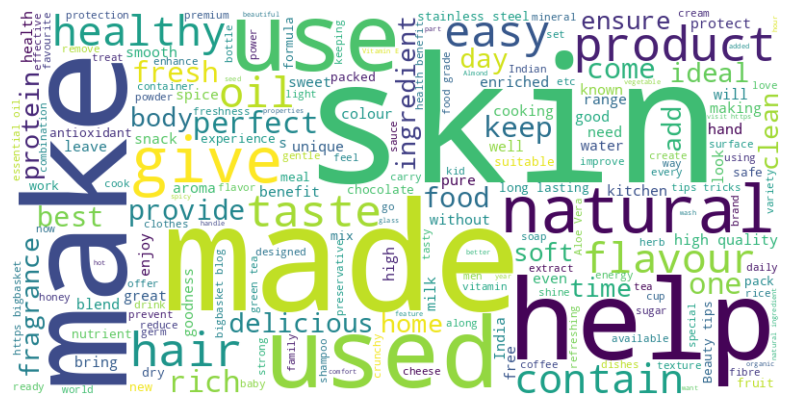

In [78]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Generate a word cloud image for high review count descriptions
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    width=800,
    height=400
).generate(high_review_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


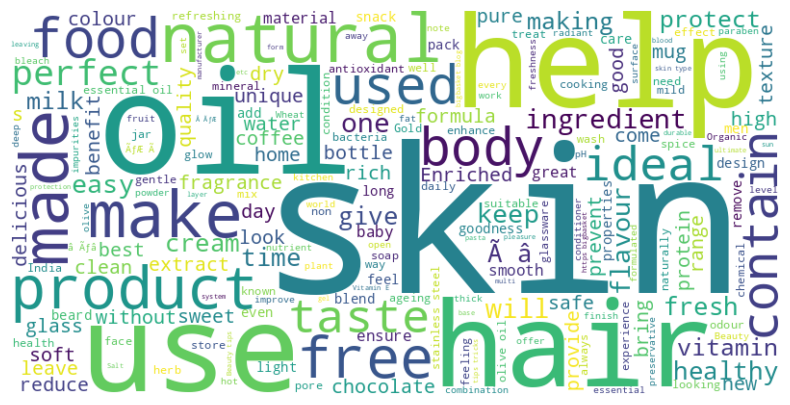

In [89]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data.csv')

# Define thresholds for high ratings and review counts
rating_threshold = data['product_rating'].quantile(0.9)
review_count_threshold = data['customer_reviews_count'].quantile(0.9)

# Filter the data based on both high ratings and review counts
high_rating_and_review_data = data[
    (data['product_rating'] > rating_threshold) & 
    (data['customer_reviews_count'] > review_count_threshold)
]['product_description']

# Combine all relevant product descriptions into a single string
high_rating_and_review_text = ' '.join(high_rating_and_review_data.dropna().astype(str))

# Generate a word cloud image for high rating and review count descriptions
wordcloud = WordCloud(
    stopwords=STOPWORDS,
    background_color='white',
    width=800,
    height=400
).generate(high_rating_and_review_text)

# Display the generated image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


- Focus on Natural and Healthful Products: The prominence of words like "natural," "healthy," "vitamin," and "organic" suggests a strong emphasis on the natural and health benefits of products.

- Quality and Experience: Words such as "perfect," "ideal," "easy," "rich," and "premium" indicate that quality and ease of use are important selling points.

- Skincare and Beauty: Terms like "skin," "body," "soft," "smooth," "cream," and "fragrance" are prevalent, indicating a focus on skincare and beauty products.

- Dietary Products: The visibility of "food," "taste," "flavour," and "chocolate" suggests the descriptions also include food-related items, potentially with a slant towards healthful eating.

- Ingredient Transparency: The frequent appearance of "ingredient" implies that transparency around product composition is likely valued by consumers.